In [1]:
import pandas as pd
import sklearn

diabetes = pd.read_csv('../data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
assert len(diabetes) == 70692

En este pequeño experimento previo, se pretende hacer una búsqueda de "valores raros" (outliers) en cada una de las clases del conjunto de datos.

Para ello, se utilizará la técnica de agrupamiento DBSCAN vista en clase, técnica determinista de agrupamiento en nucleos basada en la densidad de los puntos por un valor épsilon (ε) que refiere al radio de dichos núcleos y un valor min_samples de la cantidad mínima de puntos para cada núcleo.

Nuestro objetivo será encontrar un conjunto de puntos bien compacto para cada clase (y : Diabetes_binary) del conjunto de datos que se pueda diferenciar de los valores ruido o outliers con el fin de comparar qué columnas son las que el algoritmo considera que son susceptibles a interferir en la compacidad de los núcleos más característicos de cada clase.

Como tarea principal, se creará una función agrupador que recibe como parámetros un dataset, un valor épsilon y un valor de min_samples.
La función devolverá a su vez el modelo DBSCAN de scikit_learn ya entrenado.

In [2]:
def agrupador(dataset, e=10, min=10):
    agrupador_DBSCAN = sklearn.cluster.DBSCAN(eps=e,min_samples=min)
    agrupador_DBSCAN.fit(dataset)
    return agrupador_DBSCAN

In [3]:
prueba = agrupador(diabetes)

In [4]:
print(f"Número de labels : {len(prueba.labels_)}", 
      f"Conjunto de núcleos : {set(prueba.labels_)}", 
      "Ejemplos de outlier :", sep='\n')
diabetes[prueba.labels_ == -1][:5]

Número de labels : 70692
Conjunto de núcleos : {np.int64(0), np.int64(-1)}
Ejemplos de outlier :


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
553,0.0,0.0,0.0,1.0,92.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,2.0,30.0,0.0,0.0,0.0,2.0,4.0,7.0
612,0.0,0.0,1.0,1.0,98.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,20.0,0.0,0.0,10.0,6.0,7.0
3172,0.0,1.0,0.0,1.0,76.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,4.0,15.0,15.0,1.0,0.0,5.0,4.0,2.0
5161,0.0,0.0,0.0,1.0,73.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,3.0,20.0,5.0,0.0,0.0,10.0,6.0,5.0
17222,0.0,0.0,0.0,1.0,87.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,30.0,7.0,0.0,0.0,5.0,6.0,8.0


Una vez comprobado su funcionamiento con el conjunto de datos en su totalidad y vista la duración media de ejecutar el algoritmo con los parámetros por defecto, pasaremos a construir los conjuntos de datos que nos conciernen, es decir, aquellos separados por cada clasificador.

In [5]:
diabetes0 = diabetes[diabetes['Diabetes_binary'] == 0.0]
diabetes1 = diabetes[diabetes['Diabetes_binary'] == 1.0]
print("Diabetes0:", len(diabetes0), "\nDiabetes1:", len(diabetes1))

Diabetes0: 35346 
Diabetes1: 35346


In [6]:
diabetes0 = diabetes0.drop(columns = 'Diabetes_binary')
diabetes1 = diabetes1.drop(columns = 'Diabetes_binary')

assert 'Diabetes_binary' in diabetes.columns
assert 'Diabetes_binary' not in diabetes0.columns
assert 'Diabetes_binary' not in diabetes1.columns

El artículo de la referencia [[1]](https://doi.org/10.1023/A:1009745219419) sobre las aplicaciones de DBSCAN, citamos en las reflexiones de la página 183:
> * The user gives a value for k (default is k = 2∗dimension − 1).
> * The system computes and displays the k-distance plot for a sample of the database.
> * The user selects an object as the threshold object and the k-distance value of this object is used as the Eps value; MinCard is set to k + 1 (if the user can estimate the percentage of noise, the system can derive a proposal for the threshold object from it).

Por lo que utilizaremos min (MinCard / min_samples) = (2*(dataset_dim-1))+1 , y para épsilon, para no entrar en calculos y graficas de distancias, utilizaremos como cota inferia el propuesto por la librería de DBSCAN [[2]](https://scikit-learn.org/dev/modules/generated/sklearn.cluster.DBSCAN.html) por defecto e= 0.5 e incrementaremos su valor hasta conseguir que se agrupen todos en un mismo núcleo y así ver cuándo se forman los primeros outliers. Tendremos en cuenta sin embargo que el número de outliers no sea excesivamente grante, por lo que requeriremos que la cantidad de outliers sea inferior al 1% del total de datos del dataset de entrada. Esto está motivado en que no buscamos un agrupamiento óptimo, si no la detección de una cantidad de outliers similar y significativa en sendos conjuntos.

El cálculo de ε y min se llevará a cabo en la función parametros_agrupador.
La función parametros_agrupador únicamente necesita del conjunto de datos como entrada aunque dispone de un centinela, verbose, para ir reflejando por consola el progreso de la búsqueda.
Como salida, la función devolverá el modelo entrenado con la función agrupador (previamente definida) y los parámetros encontrados de épsilon y min_samples.

In [7]:
def parametros_agrupador(dataset, verbose=False):
    k = 2 * ( len(diabetes0.columns) - 1 )
    epsilon = 5
    agrupador_calculado = agrupador(dataset, e=epsilon, min=k+1)
    while (len(set(agrupador_calculado.labels_)) > 2 or list(agrupador_calculado.labels_).count(-1) > len(dataset)/100):
        if verbose:
            nucleos = len(set(agrupador_calculado.labels_)) + 1
            print(f"ε:{epsilon} genera {nucleos} núcleo{'s' if nucleos > 1 else ''} ...")
        epsilon = 1 if epsilon < 1 else epsilon + 1
        agrupador_calculado = agrupador(dataset, e=epsilon, min=k+1)
    if verbose:
            print(f"ε:{epsilon} genera 1 núcleo y {list(agrupador_calculado.labels_).count(-1)} outliers.")
    return (agrupador_calculado, epsilon, k+1)


**ATENCIÓN**: Este bloque de código se utiliza para calcular épsilon y min_samples. Puede continuar al bloque siguiente donde encontrará más información.

In [8]:
print("calculando ε para agrupador_no_diabetes:")
agrupador_no_diabetes, e_no_diabetes, min_no_diabetes = parametros_agrupador(diabetes0, True)

print("\ncalculando ε para agrupador_diabetes:")
agrupador_diabetes, e_diabetes, min_diabetes = parametros_agrupador(diabetes1, True)

calculando ε para agrupador_no_diabetes:
ε:5 genera 6 núcleos ...
ε:6 genera 4 núcleos ...
ε:7 genera 1 núcleo y 241 outliers.

calculando ε para agrupador_diabetes:
ε:5 genera 5 núcleos ...
ε:6 genera 3 núcleos ...
ε:7 genera 1 núcleo y 194 outliers.


Debido a que DBSCAN es determinista, una vez hemos encontrado los valores para las dos particiones (que resultan ser los mismos parámetros), incluímos por aquí el código resultante para no tener que lanzar el proceso previo entero pues podría tardar varios minutos.

**NOTA**: Si ha lanzado el bloque de código previo, no es necesario ejecutar éste.

In [9]:
e_no_diabetes = 7
min_no_diabetes = 41
agrupador_no_diabetes = agrupador(diabetes0, e_no_diabetes, min_no_diabetes)

e_diabetes = 7
min_diabetes = 41
agrupador_diabetes = agrupador(diabetes1, e_diabetes, min_diabetes)

Ahora pasaremos a la visualización y comparación de los outliers, para ello, por comodidad, visualizaremos primero los outliers referentes a las columnas con valores binarios del conjunto de datos.
Estas son:

+ HighBP
+ HighChol
+ CholCheck
+ Smoker
+ Stroke
+ HeartDiseaseorAttack
+ PhysActivity
+ Fruits
+ Veggies
+ HvyAlcoholConsump
+ AnyHealthcare
+ NoDocbcCost
+ DiffWalk
+ Sex

In [10]:
columnas_binarias = ["HighBP", "HighChol", "CholCheck", "Smoker", "Stroke", 
 "HeartDiseaseorAttack", "PhysActivity", "Fruits", "Veggies", 
 "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost", "DiffWalk", "Sex"]

print("Número de campos binarios:", len(columnas_binarias))

Número de campos binarios: 14


In [11]:
indices_columnas_binarias = dict()
for nombre_columna in columnas_binarias:
    if nombre_columna in agrupador_no_diabetes.feature_names_in_:
        indices_columnas_binarias[nombre_columna] = list(agrupador_no_diabetes.feature_names_in_).index(nombre_columna)
print("(NOMBRE COLUMNA, POSICIÓN EN DATASET)", *indices_columnas_binarias.items(), sep='\n')

(NOMBRE COLUMNA, POSICIÓN EN DATASET)
('HighBP', 0)
('HighChol', 1)
('CholCheck', 2)
('Smoker', 4)
('Stroke', 5)
('HeartDiseaseorAttack', 6)
('PhysActivity', 7)
('Fruits', 8)
('Veggies', 9)
('HvyAlcoholConsump', 10)
('AnyHealthcare', 11)
('NoDocbcCost', 12)
('DiffWalk', 16)
('Sex', 17)


<Axes: xlabel='STRAT'>

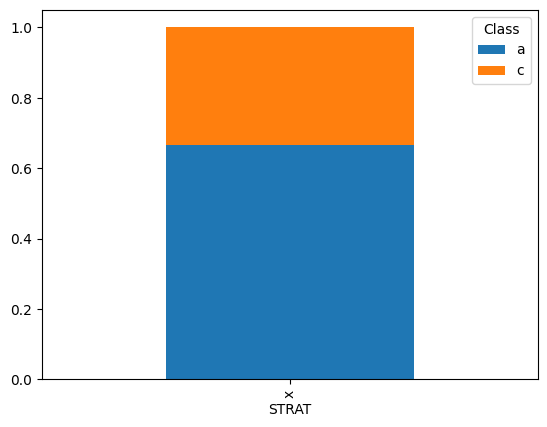

In [12]:
# Ejemplo de uso de stackoverflow con el que nos hemos guiado para visualizar los datos binarios:
# https://stackoverflow.com/questions/56251848/how-do-i-make-pandas-catagorical-stacked-bar-chart-scale-to-100/56259605
df = pd.DataFrame({'Class': ['a', 'c', 'a'],'STRAT': ['x', 'x', 'x'],'value': [33, 40, 59]})
df_pct = (df.groupby(['STRAT','Class'])['value'].count()/df.groupby(['STRAT'])['value'].count())
df_pct.unstack().plot.bar(stacked=True)

In [13]:
def comparador_binario(nombre_columna):
    series0_nucleo = pd.Series(diabetes0[agrupador_no_diabetes.labels_ == 0][nombre_columna])
    series0_ruido = pd.Series(diabetes0[agrupador_no_diabetes.labels_ == -1][nombre_columna])
    series1_nucleo = pd.Series(diabetes1[agrupador_diabetes.labels_ == 0][nombre_columna])
    series1_ruido = pd.Series(diabetes1[agrupador_diabetes.labels_ == -1][nombre_columna])

    etiquetas0 = ['Sano - core'] * len(series0_nucleo) + ['Sano - ruido'] * len(series0_ruido)  
    etiquetas1 = ['Diab - core'] * len(series1_nucleo) + ['Diab - ruido'] * len(series1_ruido)  
    etiquetas = etiquetas0 + etiquetas1
    valores = pd.concat([series0_nucleo, series0_ruido, series1_nucleo, series1_ruido])

    df = pd.DataFrame({nombre_columna: etiquetas, 'Y': valores, 'value': valores})
    df_pct = (df.groupby([nombre_columna,'Y'])['value'].count()/df.groupby([nombre_columna])['value'].count())
    df_pct.unstack().plot.bar(stacked=True, rot=0)
    


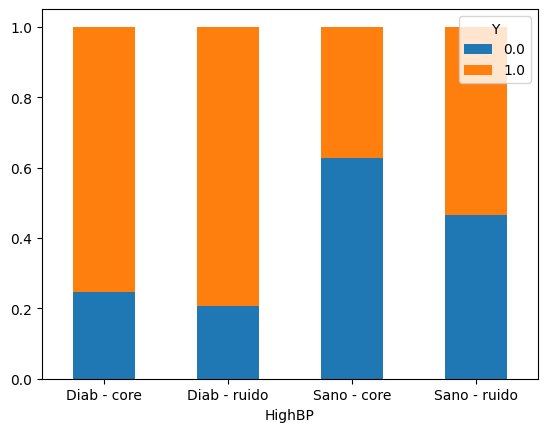

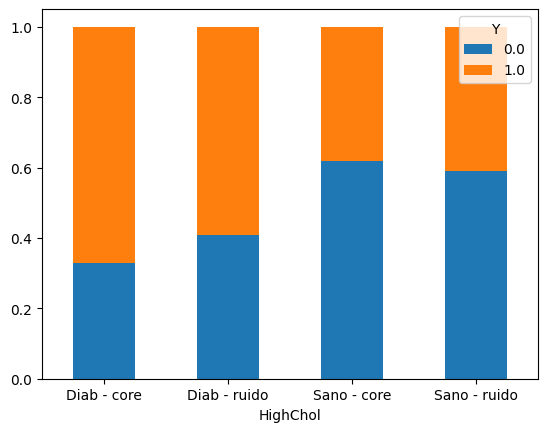

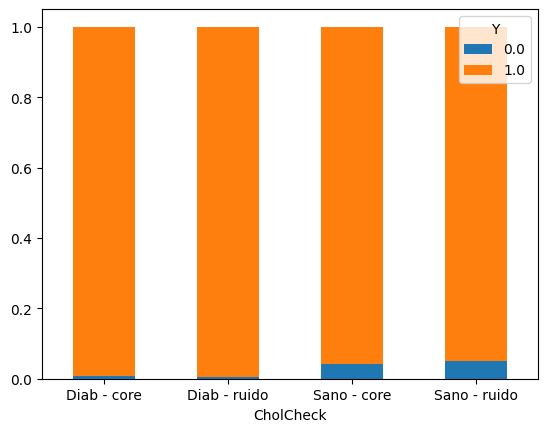

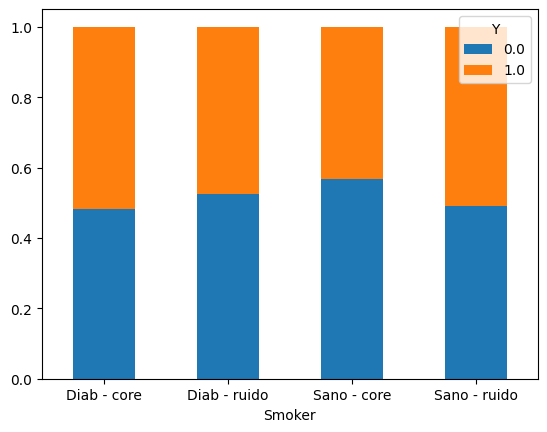

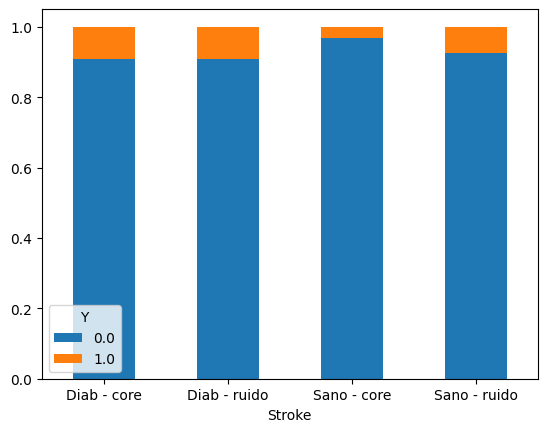

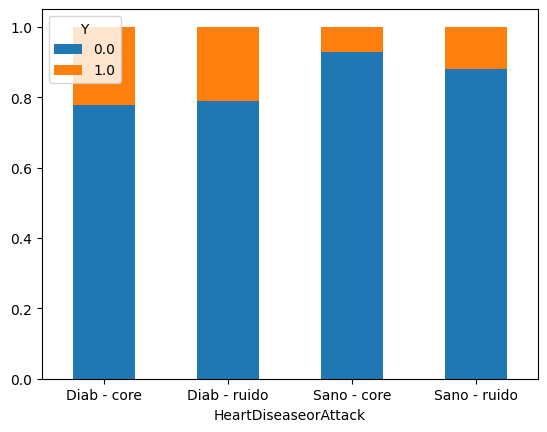

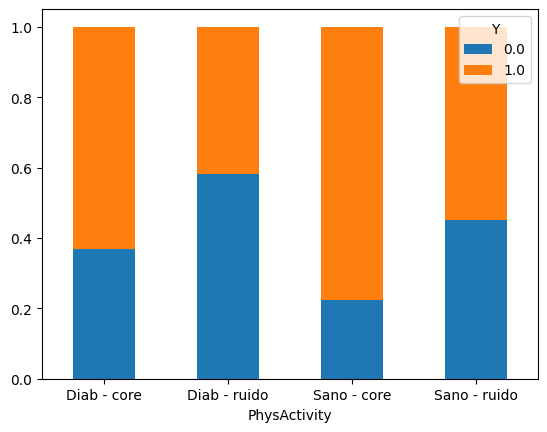

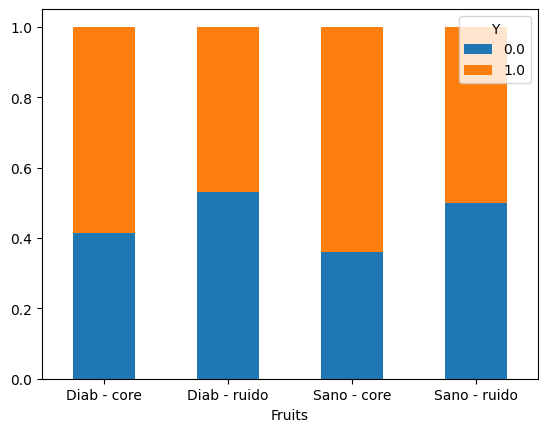

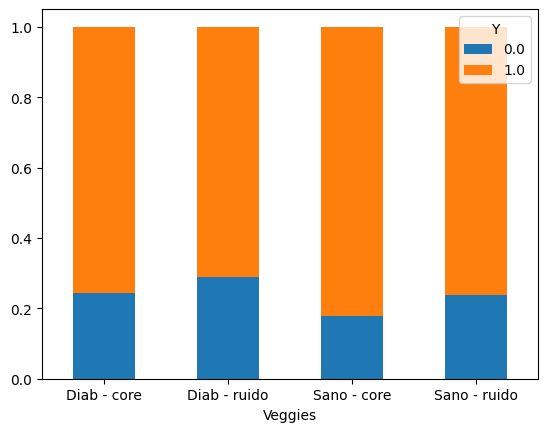

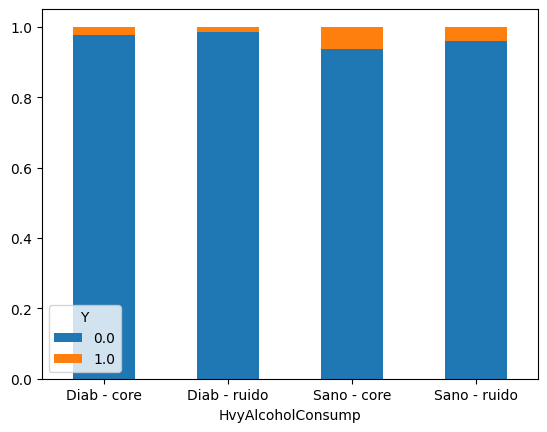

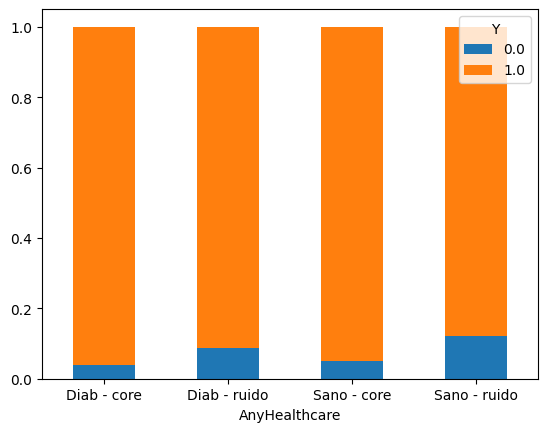

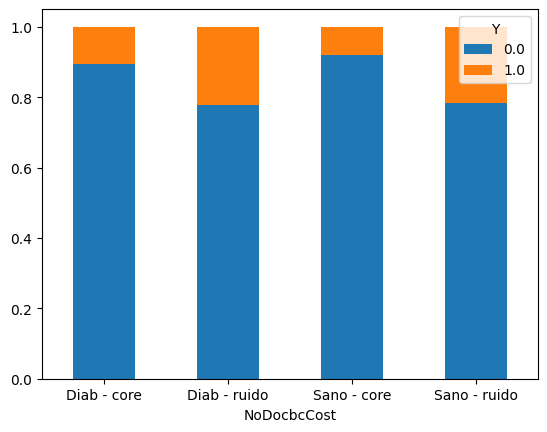

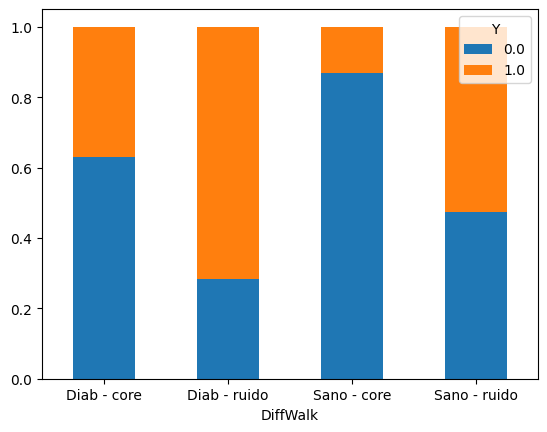

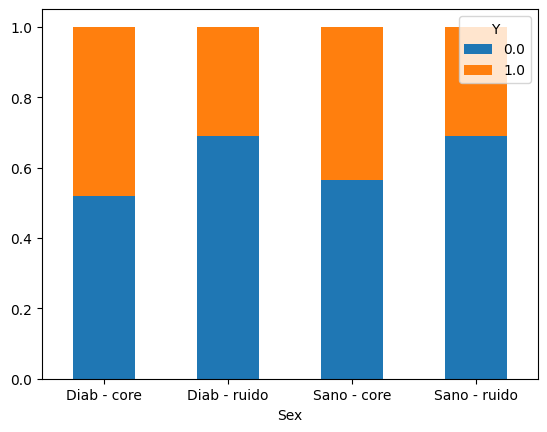

In [14]:
for columna in indices_columnas_binarias:
    comparador_binario(columna)

PhysActivity y DiffWalk son las dos columnas binarias que presentan mayor discrepancia entre sus puntos en el núcleo y sus puntos de ruido.

----

Ahora, reutilizando el código, crearemos un método de visualización de las variables ordinales de las que tenemos que pertenecen a algunas métricas externas, siendo así también categóricas y que permiten una visualización en gráficos de barras apiladas:

+ GenHlth (Escala de salud general (1=excelente, 2=muy buena, 3=buena, 4=regular, 5=deficitaria))
+ Age [(métrica AGEG5YR)](https://www.icpsr.umich.edu/web/NAHDAP/studies/34085/datasets/0001/variables/AGEG5YR?archive=NAHDAP)
+ Education [(métrica EDUCA)](https://www.icpsr.umich.edu/web/NAHDAP/studies/34085/datasets/0001/variables/EDUCA?archive=NAHDAP)
+ Income [(métrica INCOME2)](https://www.icpsr.umich.edu/web/RCMD/studies/34085/datasets/0001/variables/INCOME2?archive=RCMD)

In [15]:
columnas_categoricas = ["GenHlth", "Age", "Education", "Income"]

print("Número de campos categóricos:", len(columnas_categoricas))

Número de campos categóricos: 4


In [16]:
indices_columnas_categoricas = dict()
for nombre_columna in columnas_categoricas:
    if nombre_columna in agrupador_no_diabetes.feature_names_in_:
        indices_columnas_categoricas[nombre_columna] = list(agrupador_no_diabetes.feature_names_in_).index(nombre_columna)
print("(NOMBRE COLUMNA, POSICIÓN EN DATASET)", *indices_columnas_categoricas.items(), sep='\n')

(NOMBRE COLUMNA, POSICIÓN EN DATASET)
('GenHlth', 13)
('Age', 18)
('Education', 19)
('Income', 20)


In [17]:
def comparador_categorico(nombre_columna):
    series0_nucleo = pd.Series(diabetes0[agrupador_no_diabetes.labels_ == 0][nombre_columna])
    series0_ruido = pd.Series(diabetes0[agrupador_no_diabetes.labels_ == -1][nombre_columna])
    series1_nucleo = pd.Series(diabetes1[agrupador_diabetes.labels_ == 0][nombre_columna])
    series1_ruido = pd.Series(diabetes1[agrupador_diabetes.labels_ == -1][nombre_columna])

    etiquetas0 = ['Sano - core'] * len(series0_nucleo) + ['Sano - ruido'] * len(series0_ruido)  
    etiquetas1 = ['Diab - core'] * len(series1_nucleo) + ['Diab - ruido'] * len(series1_ruido)  
    etiquetas = etiquetas0 + etiquetas1
    valores = pd.concat([series0_nucleo, series0_ruido, series1_nucleo, series1_ruido])

    df = pd.DataFrame({nombre_columna: etiquetas, 'Y': valores, 'value': valores})
    df_pct = (df.groupby([nombre_columna,'Y'])['value'].count()/df.groupby([nombre_columna])['value'].count())
    df_pct.unstack().plot.bar(stacked=True, rot=0)
    


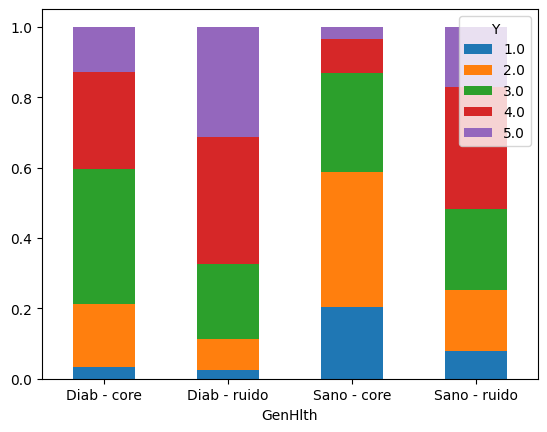

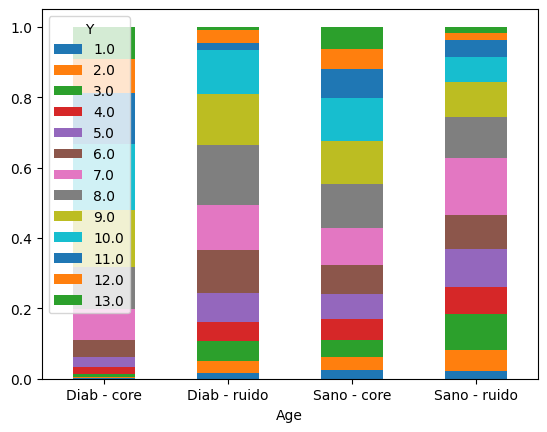

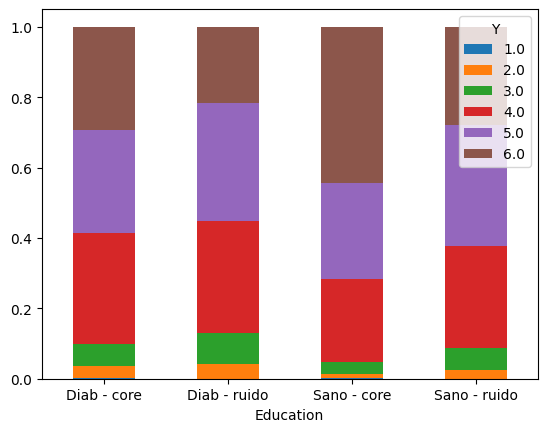

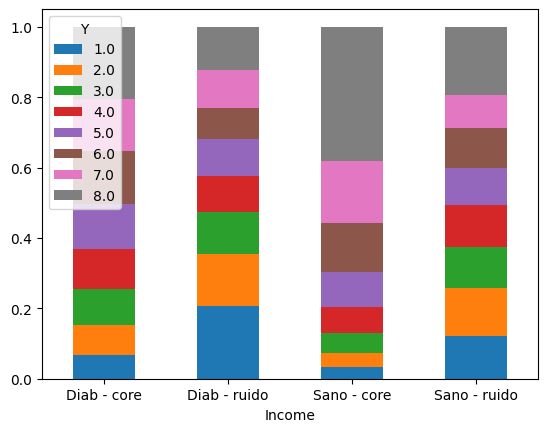

In [18]:
for columna in indices_columnas_categoricas:
    comparador_categorico(columna)

Debido a la técnica de visualización empleada, es complicado para el ojo humano advertir cómo de dispares son los conjuntos de puntos dentro del núcleo de DBSCAN y los que se consideran ruido, sobre todo aquellos con más de 6 categorías, lo que hace que la visualización de las columnas GenHlth y Education sean aceptables pero Income (8 categorías) y Age (13 categorías) sean complejas de ver si hay o no diferencias significativas.

----

Viendo que en el momento que el numero de valores que puede tomar un campo aumenta es más complicado de visualizar con un grafico de barras apiladas, para los datos enteros hemos ponderado la imposibilidad de utilizar esta técnica y por ello se empleará una técnica diferente: los gráficos de caja.

Los campos que visualizaremos con esta técnica son los siguientes:

+ BMI (Índice de Masa Corporal)
+ MentHlth (Número de últimos 30 días con baja salud mental)
+ PhysHlth (Número de últimos 30 días con baja salud física)

In [19]:
columnas_enteras = ["BMI", "MentHlth", "PhysHlth"]

print("Número de campos enteros:", len(columnas_enteras))

Número de campos enteros: 3


In [20]:
indices_columnas_enteras = dict()
for nombre_columna in columnas_enteras:
    if nombre_columna in agrupador_no_diabetes.feature_names_in_:
        indices_columnas_enteras[nombre_columna] = list(agrupador_no_diabetes.feature_names_in_).index(nombre_columna)
print("(NOMBRE COLUMNA, POSICIÓN EN DATASET)", *indices_columnas_enteras.items(), sep='\n')

(NOMBRE COLUMNA, POSICIÓN EN DATASET)
('BMI', 3)
('MentHlth', 14)
('PhysHlth', 15)


In [21]:
def comparador_entero(nombre_columna):
    series0_nucleo = pd.Series(diabetes0[agrupador_no_diabetes.labels_ == 0][nombre_columna], name='Sano core')
    series0_ruido = pd.Series(diabetes0[agrupador_no_diabetes.labels_ == -1][nombre_columna], name='Sano ruido')
    series1_nucleo = pd.Series(diabetes1[agrupador_diabetes.labels_ == 0][nombre_columna], name='Diab core')
    series1_ruido = pd.Series(diabetes1[agrupador_diabetes.labels_ == -1][nombre_columna], name='Diab ruido')
    
    df = pd.concat([series0_nucleo, series0_ruido, series1_nucleo, series1_ruido], axis=1)

    df.plot.box(grid=False, column=['Sano core', 'Sano ruido', 'Diab core', 'Diab ruido'], title=nombre_columna)  

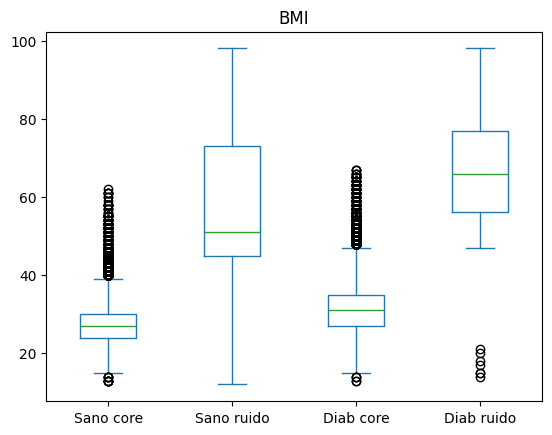

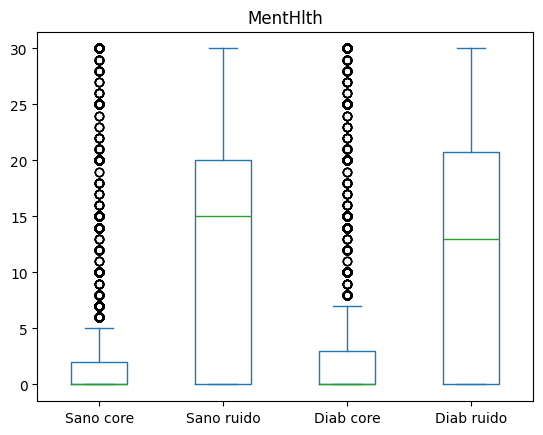

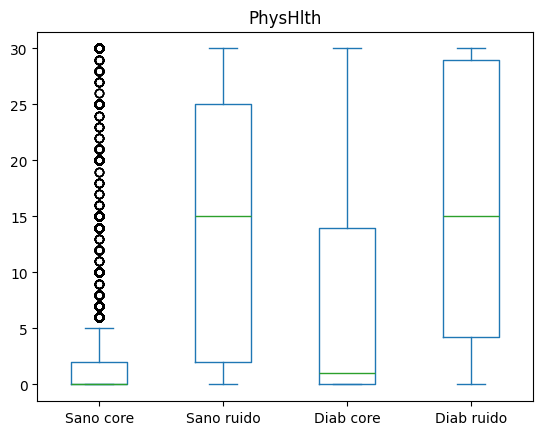

In [22]:
for columna in indices_columnas_enteras:
    comparador_entero(columna)

Podemos ver que el campo que parece ser más propicio a generar pntos de ruido es BMI (Índice de Masa Corporal), que, aunque podemos ver que mantiene cierta similitud entre los clasificadores de "diabetes" / "no diabetes", sí que presenta una distrubución muy diferenciada entre el núcleo compacto calculado por DBSCAN y los puntos de ruido.

Viendo que este métod es más expresivo para campos con diferente casuística de valores, vamos a aplicarlo por últimas en los campos categóricos Income y Age que anteriormente nos dieron problema, por ver si esta representación pudiese ser significativa.

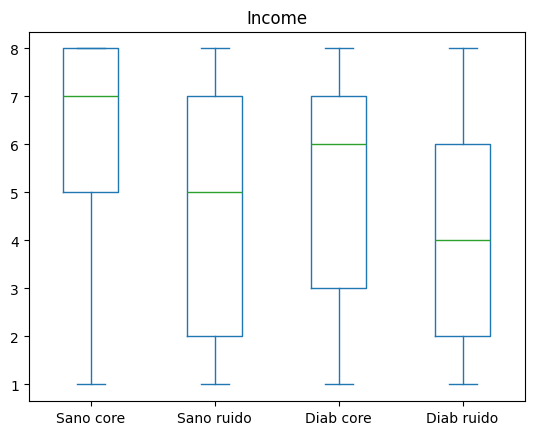

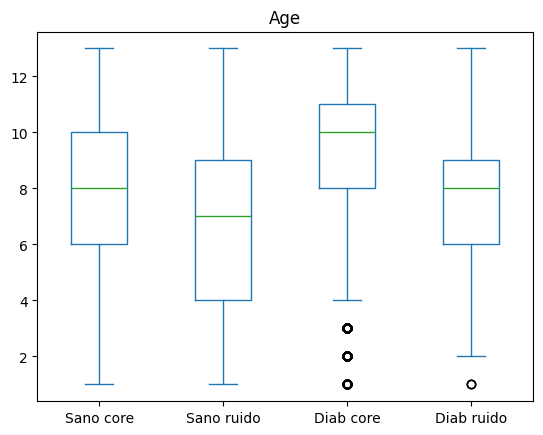

In [23]:
for columna in ['Income', 'Age']:
    comparador_entero(columna)

Con esta visualización, sí se puede ver con más claridad que ambos atributos, Income y Age, son ligeramente susceptibles a ser candidatos de generar ruido.

----

### CONCLUSIONES

Mediante la generación de outliers hemos podido comprobar dos cosas:

* En primer lugar, este estudio nos ha dado pie a **visualizar** todos los campos agrupados con la técnica de DBSCAN. Pese a haber trabajado sobre los datos del cada una de las clases predictoras del conjuto de datos como si fuesen conjunto de datos independientes, parece haber agrupado de forma parecida. Esto es que la gran mayoría de atributos parecen tener una valoración bastante uniforme independientemente de la clase predictora. Variables como **HighBP**, **HighCol** y **BMI** son las que más difieren en cuanto a dispersión entre sus valores de la clase predictora.

* Por otro lado, hemos podido advertir que hay ciertos atributos que generan más discrepancia entre los núcleos compactos de DBSCAN y los puntos de ruido generados. Nos hace pensar que, posiblemente, estos atributos sean candidatos a ser las variables más influyentes a la hora de entrenar un modelo, al menos uno basado en **distancias**, por lo que es conveniente que tengamos en cuenta esto para ser contrastado. Los atributos que, a ojo, por las técnicas de visualización parecen tener más influencia en generar outliers son: 
    + BMI (entero)
    + Income (categórico / ordinal)
    + GenHealth (categórico / ordinal)
    + PhysActivity (binario)
    + DiffWalk (binario)

Bien es cierto que hay que tener en cuenta que la técnica aplicada, basada en distancias, debería ser más sensible a los atributos enteros y a aquellos categóricos-ordinales con múltiples valores ya que las distancias serán más significativas. Sin embargo, se entiende que debido a que la gran mayoría de campos son binarios, el cálculo de las distancias de estos atributos no será tan sensible (al final, habrá distancia 0 ó 1) por la baja casuística de posibilidades.

Teniendo esto en cuenta, poder visualizar que un campo binario, como pueden ser **HighBP** o **HighCol**, tenga una diferenciación significativa, debe ser un indicador de que estos campos sean candidatos a ser variables importantes del problema.

### Bibliografía:
[1] Sander, J., Ester, M., Kriegel, HP. et al. Density-Based Clustering in Spatial Databases: The Algorithm GDBSCAN and Its Applications. Data Mining and Knowledge Discovery 2, 169–194 (1998). https://doi.org/10.1023/A:1009745219419

[2] Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay; 12(85):2825−2830, (2011). DBSCAN https://scikit-learn.org/dev/modules/generated/sklearn.cluster.DBSCAN.html

[3] McKinney, W. (2020). pandas.DataFrame.plot.bar (Version 2.2)  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

[4] McKinney, W. (2020). pandas.DataFrame.plot.box (Version 2.2)  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.box.html